In [2]:
from google.colab import files
uploads=files.upload()

Saving kaggle.json to kaggle (2).json


In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 27 04:46 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install kaggle

In [7]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
#!kaggle competitions download -c tgs-salt-identification-challenge

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [9]:
!pip install gensim

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [0]:
con = sqlite3.connect('./amazon/database.sqlite') 

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [0]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [15]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [19]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [20]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [21]:

final['Score'].value_counts()

positive    307063
negative     57110
Name: Score, dtype: int64

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence)
    
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [26]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [0]:
final_data=final.head(100000)

In [0]:
train_data=final_data.head(60000)
cv_data=final_data[60000:80000]
test_data=final_data[80000:100000]

# Bag of words

In [121]:
count_vect = CountVectorizer()
bag_of_words = count_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(bag_of_words))
print("the shape of out text BOW vectorizer ",bag_of_words.get_shape())
print("the number of unique words ", bag_of_words.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 30087)
the number of unique words  30087


In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
y=np.array(train_data['Score'])

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [125]:
y.shape

(60000,)

In [0]:
cv_bag_of_words=count_vect.transform(cv_data['CleanedText'])
y_cv=np.array(cv_data['Score'])

In [0]:
cv_bag_of_words1=cv_bag_of_words[0:5000,:]
cv_bag_of_words2=cv_bag_of_words[5000:10000,:]
cv_bag_of_words3=cv_bag_of_words[10000:15000,:]
cv_bag_of_words4=cv_bag_of_words[15000:20000,:]
cv_bag_of_words_batches=[cv_bag_of_words1,cv_bag_of_words2,cv_bag_of_words3,cv_bag_of_words4]

In [128]:
cv_bag_of_words1.shape

(5000, 30087)

In [0]:
from sklearn.metrics import confusion_matrix

In [130]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(bag_of_words, y)
    cv_pred=list()
    # predict the response on the crossvalidation train
    for cv_batch in cv_bag_of_words_batches:
      batch_pred = knn.predict(cv_batch)
      cv_pred.append(batch_pred)
    cv_pred=np.array(cv_pred)
    cv_pred=cv_pred.flatten()
    # evaluate CV accuracy
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    #cm=confusion_matrix(y_cv,cv_pred)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    cm=confusion_matrix(y_cv, cv_pred)
    print(cm)
    print('CV accuracy for k = {} is {} and  f1-score = {}'.format(i,acc,f1))

[[  610  2152]
 [ 1271 15967]]
CV accuracy for k = 1 is 82.88499999999999 and  f1-score = 0.82885
[[  397  2365]
 [  510 16728]]
CV accuracy for k = 3 is 85.625 and  f1-score = 0.85625
[[  281  2481]
 [  246 16992]]
CV accuracy for k = 5 is 86.36500000000001 and  f1-score = 0.86365
[[  212  2550]
 [  156 17082]]
CV accuracy for k = 7 is 86.47 and  f1-score = 0.8646999999999999
[[  162  2600]
 [  104 17134]]
CV accuracy for k = 9 is 86.48 and  f1-score = 0.8648
[[  131  2631]
 [   77 17161]]
CV accuracy for k = 11 is 86.46000000000001 and  f1-score = 0.8646
[[  102  2660]
 [   60 17178]]
CV accuracy for k = 13 is 86.4 and  f1-score = 0.864
[[   88  2674]
 [   52 17186]]
CV accuracy for k = 15 is 86.37 and  f1-score = 0.8637
[[   72  2690]
 [   44 17194]]
CV accuracy for k = 17 is 86.33 and  f1-score = 0.8633
[[   61  2701]
 [   34 17204]]
CV accuracy for k = 19 is 86.325 and  f1-score = 0.8632499999999999
[[   67  2695]
 [   27 17211]]
CV accuracy for k = 21 is 86.39 and  f1-score = 0.8

In [0]:
test_bag_of_words=count_vect.transform(test_data['CleanedText'])
y_test=np.array(test_data['Score'])

In [0]:
test_bag_of_words1=test_bag_of_words[0:5000,:]
test_bag_of_words2=test_bag_of_words[5000:10000,:]
test_bag_of_words3=test_bag_of_words[10000:15000,:]
test_bag_of_words4=test_bag_of_words[15000:20000,:]
test_bag_of_words_batches=[test_bag_of_words1,test_bag_of_words2,test_bag_of_words3,test_bag_of_words4]

Test accuracy for algorithm - brute and  k = 3 is 83.73 and f1-score is 0.8373000000000002
Test accuracy for algorithm - kd_tree and  k = 3 is 83.73 and f1-score is 0.8373000000000002


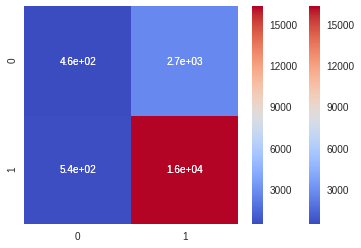

In [134]:
algorithms=['brute','kd_tree']
for alg in algorithms:
    knn = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree')
    knn.fit(bag_of_words,y)
    pred=list()
    for test_batch in test_bag_of_words_batches:      
      batch_pred = knn.predict(test_batch)
      pred.append(batch_pred)
    pred=np.array(pred)
    pred=pred.flatten()
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    print('Test accuracy for algorithm - {} and  k = 3 is {} and f1-score is {}' .format(alg,acc,f1))
    cm=confusion_matrix(y_test, pred)
    sns.heatmap(cm,cmap='coolwarm',annot=True)

*Optimal K for bag of words is 9  and the test accuracy is 85.65 cross validation accuracy is 83.73 *

# **TF-IDF**

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 874120)
the number of unique words including both unigrams and bigrams  874120


In [0]:
cv_final_tf_idf=tf_idf_vect.transform(cv_data['CleanedText'])
y_cv=np.array(cv_data['Score'])

In [0]:
cv_final_tf_idf1=cv_final_tf_idf[0:5000,:]
cv_final_tf_idf2=cv_final_tf_idf[5000:10000,:]
cv_final_tf_idf3=cv_final_tf_idf[10000:15000,:]
cv_final_tf_idf4=cv_final_tf_idf[15000:20000,:]
cv_final_tf_idf_batches=[cv_final_tf_idf1,cv_final_tf_idf2,cv_final_tf_idf3,cv_final_tf_idf4]

In [138]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(final_tf_idf, y)

    # predict the response on the crossvalidation train
    cv_pred=list()
    # predict the response on the crossvalidation train
    for cv_batch in cv_final_tf_idf_batches:
      batch_pred = knn.predict(cv_batch)
      cv_pred.append(batch_pred)
    cv_pred=np.array(cv_pred)
    cv_pred=cv_pred.flatten()
    # evaluate CV accuracy
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)

    cm=confusion_matrix(y_cv, cv_pred)
    print(cm)
    print('CV accuracy for k = {} is {} and  f1-score = {}'.format(i,acc,f1))

[[  949  1813]
 [ 1671 15567]]
CV accuracy for k = 1 is 82.58 and  f1-score = 0.8258000000000001
[[  738  2024]
 [  685 16553]]
CV accuracy for k = 3 is 86.455 and  f1-score = 0.86455
[[  628  2134]
 [  342 16896]]
CV accuracy for k = 5 is 87.62 and  f1-score = 0.8762
[[  547  2215]
 [  239 16999]]
CV accuracy for k = 7 is 87.72999999999999 and  f1-score = 0.8773
[[  498  2264]
 [  158 17080]]
CV accuracy for k = 9 is 87.89 and  f1-score = 0.8789
[[  472  2290]
 [  128 17110]]
CV accuracy for k = 11 is 87.91 and  f1-score = 0.8791
[[  442  2320]
 [  100 17138]]
CV accuracy for k = 13 is 87.9 and  f1-score = 0.879
[[  414  2348]
 [   84 17154]]
CV accuracy for k = 15 is 87.83999999999999 and  f1-score = 0.8784
[[  400  2362]
 [   69 17169]]
CV accuracy for k = 17 is 87.845 and  f1-score = 0.8784500000000001
[[  372  2390]
 [   64 17174]]
CV accuracy for k = 19 is 87.72999999999999 and  f1-score = 0.8773
[[  340  2422]
 [   58 17180]]
CV accuracy for k = 21 is 87.6 and  f1-score = 0.8759

In [0]:
test_final_tf_idf=tf_idf_vect.transform(test_data['CleanedText'])
y_test=np.array(cv_data['Score'])

In [0]:
test_final_tf_idf1=test_final_tf_idf[0:5000,:]
test_final_tf_idf2=test_final_tf_idf[5000:10000,:]
test_final_tf_idf3=test_final_tf_idf[10000:15000,:]
test_final_tf_idf4=test_final_tf_idf[15000:20000,:]
test_final_tf_idf_batches=[test_final_tf_idf1,test_final_tf_idf2,test_final_tf_idf3,test_final_tf_idf4]

Test accuracy for algorithm - brute and  k = 3 is 80.75 and f1-score is 0.8075
[[  205  2557]
 [ 1293 15945]]
Test accuracy for algorithm - kd_tree and  k = 3 is 80.75 and f1-score is 0.8075
[[  205  2557]
 [ 1293 15945]]


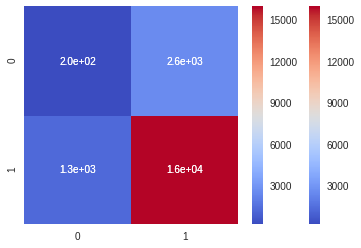

In [144]:
algorithms=['brute','kd_tree']
for alg in algorithms:
    knn = KNeighborsClassifier(n_neighbors=3,algorithm=alg)
    knn.fit(final_tf_idf,y)
    pred=list()
    for test_batch in test_final_tf_idf_batches:      
      batch_pred = knn.predict(test_batch)
      pred.append(batch_pred)
    pred=np.array(pred)
    pred=pred.flatten()
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    print('Test accuracy for algorithm - {} and  k = 3 is {} and f1-score is {}' .format(alg,acc,f1))
    cm=confusion_matrix(y_test, pred)
    print(cm)
    sns.heatmap(cm,cmap='coolwarm',annot=True)
    

*Optimal K for bag of words is 11  and the test accuracy is 87.9 cross validation accuracy is 83.8*

# **Word to vec**

In [0]:
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [33]:
len(list_of_sent)

60000

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [35]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10210
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand']


# Avg Word to Vec

In [0]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

*Transforming cross validation data*

In [0]:
i=0
cv_list_of_sent=[]
for sent in cv_data['CleanedText'].values:
     cv_list_of_sent.append(sent.split())

In [38]:
len(cv_list_of_sent)

20000

In [0]:
y_cv=np.array(cv_data['Score'])

In [40]:
y_cv.shape

(20000,)

In [0]:
cv_sent_vectors = []
for sent in cv_list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_sent_vectors.append(sent_vec)

In [42]:
cv_sent_vectors[0]

array([ 0.1293821 ,  0.44440115, -0.0641209 , -0.38645473,  0.0035178 ,
       -0.00774133,  0.39929006, -0.05636174, -0.031571  , -0.00538722,
       -0.11928659,  0.40651485, -0.08679049,  0.54306923, -0.63699703,
       -0.27302073,  0.11034759, -0.09056387,  0.09269256,  0.08742533,
        0.42986796,  0.5511942 , -0.26738661, -0.5824515 ,  1.00439468,
       -0.51839031, -0.12055616, -0.02916124,  1.04591703,  0.06134023,
       -0.37444932, -0.13481984,  0.15269877,  0.19145486, -0.64563406,
       -0.34795959,  1.13133107,  0.47716601,  0.2957113 , -0.23769696,
        0.361264  , -0.65826652, -0.14786522, -0.23847861, -0.02762349,
        0.68666485, -0.81186051,  0.43143571,  0.217891  , -0.10630193])

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [157]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(sent_vectors, y)

    # predict the response on the crossvalidation train
    cv_pred = knn.predict(cv_sent_vectors)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    
    cm=confusion_matrix(y_cv, cv_pred)
    print(cm)
    print('CV accuracy for k = {} is {} and  f1-score = {}'.format(i,acc,f1))

[[ 1168  1594]
 [ 1407 15831]]
CV accuracy for k = 1 is 84.995 and  f1-score = 0.84995
[[ 1046  1716]
 [  712 16526]]
CV accuracy for k = 3 is 87.86 and  f1-score = 0.8785999999999999
[[  977  1785]
 [  517 16721]]
CV accuracy for k = 5 is 88.49000000000001 and  f1-score = 0.8849
[[  923  1839]
 [  420 16818]]
CV accuracy for k = 7 is 88.705 and  f1-score = 0.88705
[[  898  1864]
 [  337 16901]]
CV accuracy for k = 9 is 88.995 and  f1-score = 0.88995
[[  874  1888]
 [  301 16937]]
CV accuracy for k = 11 is 89.05499999999999 and  f1-score = 0.89055
[[  839  1923]
 [  269 16969]]
CV accuracy for k = 13 is 89.03999999999999 and  f1-score = 0.8904
[[  809  1953]
 [  240 16998]]
CV accuracy for k = 15 is 89.035 and  f1-score = 0.89035
[[  797  1965]
 [  225 17013]]
CV accuracy for k = 17 is 89.05 and  f1-score = 0.8905
[[  778  1984]
 [  225 17013]]
CV accuracy for k = 19 is 88.955 and  f1-score = 0.8895500000000001
[[  761  2001]
 [  221 17017]]
CV accuracy for k = 21 is 88.89 and  f1-scor

In [0]:
i=0
test_list_of_sent=[]
for sent in test_data['CleanedText'].values:
     test_list_of_sent.append(sent.split())

In [0]:
test_sent_vectors = []
for sent in test_list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)

In [0]:
y_test=np.array(test_data['Score'])

In [0]:
test_sent_vectors=np.array(test_sent_vectors)

In [0]:
test_sent_vectors_1=test_sent_vectors[0:5000]
test_sent_vectors_2=test_sent_vectors[5000:10000]
test_sent_vectors_3=test_sent_vectors[10000:15000]
test_sent_vectors_4=test_sent_vectors[15000:20000]
test_sent_vectors_batch=[test_sent_vectors_1,test_sent_vectors_2,test_sent_vectors_3,test_sent_vectors_4]

Test accuracy for algorithm - brute and  k = 3 is 86.105 and f1-score is 0.86105
[[ 1161  2007]
 [  772 16060]]
Test accuracy for algorithm - kd_tree and  k = 3 is 86.105 and f1-score is 0.86105
[[ 1161  2007]
 [  772 16060]]


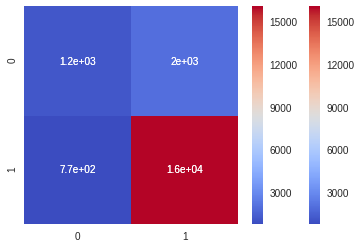

In [54]:

algorithms=['brute','kd_tree']
for alg in algorithms:
    knn = KNeighborsClassifier(n_neighbors=3,algorithm=alg)
    knn.fit(sent_vectors, y)
    pred=list()
    for test_batch in test_sent_vectors_batch:      
      batch_pred = knn.predict(test_batch)
      pred.append(batch_pred)
    pred=np.array(pred)
    pred=pred.flatten()
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    print('Test accuracy for algorithm - {} and  k = 3 is {} and f1-score is {}' .format(alg,acc,f1))
    cm=confusion_matrix(y_test, pred)
    print(cm)
    sns.heatmap(cm,cmap='coolwarm',annot=True)
    

*Optimal K for bag of words is 9  and the test accuracy is 88.8 cross validation accuracy is 87.3*

# Tf-idf W 2 Vec

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names()

In [0]:
tfidf_sent_vectors = []
row=33000;
for sent in list_of_sent[33000:37000]: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
           
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
  
    if  row%500==0:
      print(row)
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [62]:
tfidf_sent_vectors.shape

(60000, 50)

In [0]:
cv_tfidf_sent_vectors = []
row=33000;
for sent in list_of_sent[33000:37000]: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
           
            tf_idf = cv_final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
  
    if  row%500==0:
      print(row)
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [65]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(tfidf_sent_vectors, y)

    # predict the response on the crossvalidation train
    cv_pred = knn.predict(cv_tfidf_sent_vectors)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv, cv_pred, normalize=True) * float(100)
    f1=f1_score(y_cv, cv_pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    
    cm=confusion_matrix(y_cv, cv_pred)
    print(cm)
    print('CV accuracy for k = {} is {} and  f1-score = {}'.format(i,acc,f1))

[[  384  2378]
 [ 2380 14858]]
CV accuracy for k = 1 is 76.21 and  f1-score = 0.7621
[[  140  2622]
 [  931 16307]]
CV accuracy for k = 3 is 82.235 and  f1-score = 0.8223499999999999
[[   53  2709]
 [  432 16806]]
CV accuracy for k = 5 is 84.295 and  f1-score = 0.84295
[[   28  2734]
 [  203 17035]]
CV accuracy for k = 7 is 85.315 and  f1-score = 0.85315
[[   13  2749]
 [   78 17160]]
CV accuracy for k = 9 is 85.86500000000001 and  f1-score = 0.85865
[[    1  2761]
 [   26 17212]]
CV accuracy for k = 11 is 86.065 and  f1-score = 0.86065
[[    1  2761]
 [   16 17222]]
CV accuracy for k = 13 is 86.115 and  f1-score = 0.86115
[[    0  2762]
 [    8 17230]]
CV accuracy for k = 15 is 86.15 and  f1-score = 0.8615
[[    0  2762]
 [    1 17237]]
CV accuracy for k = 17 is 86.185 and  f1-score = 0.86185
[[    0  2762]
 [    0 17238]]
CV accuracy for k = 19 is 86.19 and  f1-score = 0.8619
[[    0  2762]
 [    1 17237]]
CV accuracy for k = 21 is 86.185 and  f1-score = 0.86185
[[    0  2762]
 [    

In [0]:
y_cv=np.array(cv_data['Score'])

In [0]:
test_tfidf_sent_vectors = []
row=33000;
for sent in list_of_sent[33000:37000]: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
           
            tf_idf = test_final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
  
    if  row%500==0:
      print(row)
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
test_tfidf_sent_vectors1=test_tfidf_sent_vectors[0:5000]
test_tfidf_sent_vectors2=test_tfidf_sent_vectors[5000:10000]
test_tfidf_sent_vectors3=test_tfidf_sent_vectors[10000:15000]
test_tfidf_sent_vectors4=test_tfidf_sent_vectors[15000:20000]
test_tfidf_sent_vectors_batch=[test_tfidf_sent_vectors1,test_tfidf_sent_vectors2,test_tfidf_sent_vectors3,test_tfidf_sent_vectors4]

Test accuracy for algorithm - brute and  k = 3 is 79.815 and f1-score is 0.79815
[[  229  2939]
 [ 1098 15734]]
Test accuracy for algorithm - kd_tree and  k = 3 is 79.815 and f1-score is 0.79815
[[  229  2939]
 [ 1098 15734]]


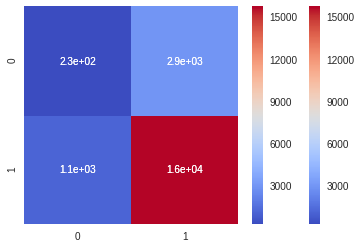

In [69]:

algorithms=['brute','kd_tree']
for alg in algorithms:
    knn = KNeighborsClassifier(n_neighbors=3,algorithm=alg)
    knn.fit(tfidf_sent_vectors, y)
    pred=list()
    for test_batch in test_tfidf_sent_vectors_batch:      
      batch_pred = knn.predict(test_batch)
      pred.append(batch_pred)
    pred=np.array(pred)
    pred=pred.flatten()
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    f1=f1_score(y_test, pred, labels=None, pos_label=1, average='micro', sample_weight=None)
    print('Test accuracy for algorithm - {} and  k = 3 is {} and f1-score is {}' .format(alg,acc,f1))
    cm=confusion_matrix(y_test, pred)
    print(cm)
    sns.heatmap(cm,cmap='coolwarm',annot=True)
    

*KNN is not a best algorithm for this data because the classification is more biased towars the Positive class as k value increases KNN it becomes more biased towards positive classes *

# Conclusion

In [71]:
!pip install prettytable


In [0]:
from prettytable import PrettyTable

In [79]:
x = PrettyTable()

x.field_names = ["Model", "Best_K", "Train Error", "Test Error"]

x.add_row(["Bag of words", 3, 85.6, 83.7])
x.add_row(["Tf-IDF", 1, 83.995, 86.65])
x.add_row(["AVG Word 2 Vec", 3, 87.19, 86.5])
x.add_row(["Tf-IDF Word 2 Vec", 3, 82.235, 79.81])
print(x)

+-------------------+--------+-------------+------------+
|       Model       | Best_K | Train Error | Test Error |
+-------------------+--------+-------------+------------+
|    Bag of words   |   3    |     85.6    |    83.7    |
|       Tf-IDF      |   1    |    83.995   |   86.65    |
|   AVG Word 2 Vec  |   3    |    87.19    |    86.5    |
| Tf-IDF Word 2 Vec |   3    |    82.235   |   79.81    |
+-------------------+--------+-------------+------------+
